# IMPORTS:


In [ ]:
!pip install myhdl
!pip install myhdlpeek


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.3/383.3 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.7 MB/s

# DESIGN:

## FETCHING:

In [ ]:
from myhdl import *
from myhdlpeek import *
def fetching(clk,out,pc,stall):
    mem = [
              0b00000001100010100110100000100000,
              0b00000001101011010111100000100010,
              0b00100011001101010000000100010001,
              0b00010010010100100000000000000010,
              0b00100011001101010000001100010001,
              0b00100011001101010000001100010001,
              0b00100011001101010000001100010001,
              0b00100011001101010000001100010001,
              0b00100011001101010000001100010001,
              0b00100011001101010000001100010001,
              0b00100011001101010000001100010001,
              0b00000010010101010110100000111000,
              0b00000001000111010000100000111000,
              0b10101110110101110000000000111010]
    #mem = open("instructions").readlines()

    @always(clk.posedge,pc,stall)
    def memo():
      if not stall:
            if pc < len(mem):
                out.next = intbv(mem[pc])
                pc.next = pc + 1


    return memo

## DECODING:

In [ ]:
from myhdl import *
def decoding(out, opcode, rs, rd, rt, sa, function, immediate,instr_index,stall):
    @always_comb
    def decode():
        if not stall:
          opcode.next = out[32:26]
          rs.next = out[26:21]
          rt.next = out[21:16]
          rd.next = out[16:11]
          sa.next = out[11:6]
          function.next= out[6:0]
          immediate.next= out[16:0]
          instr_index.next = out[26:0]
          stall.next = False


        if opcode != 0:
            if (rs == rd or rt == rd): #RAW
                stall.next = True
            elif (rd == rs or rd == rt): #WAR
                stall.next = True
        else:
            stall.next = False
        stall.next = False # to test forwarding

    return decode

## Forwarding Unit:


In [ ]:
from myhdl import *
def forwarding_unit(rs, rt, rd, forward_a, forward_b, stall):
    @always_comb
    def func():
        if not stall:
            if rs == rd:
                forward_a.next = 1  # Forward from MEM/WB stage
            elif rt == rd:
                forward_b.next = 1 # Forward from MEM/WB stage
            else:
                forward_a.next = 0
                forward_b.next = 0
    return func

## CONTROL:

In [ ]:
from myhdl import *
def con(opcode,function,opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch,stall):
    @always_comb
    def contro():
      if not stall:

        print(bin(function))
        if opcode == 0b000000 and function == 0b100000:
            opertion.next="ADD"
            regdst.next=1
            regwrite.next=1
            alusrc.next=0
            aluop.next=0b010
            memwrite.next=0
            memread.next=0
            memtoreg.next=0
            branch.next=0

            print(opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch)
        elif opcode == 0b000000 and function == 0b100010:
            opertion.next="SUB"
            regdst.next=1
            regwrite.next=1
            alusrc.next=0
            aluop.next=0b110
            memwrite.next=0
            memread.next=0
            memtoreg.next=0
            branch.next=0
            print(opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch)
        elif opcode == 0b000000 and function == 0b110110:
            opertion.next="AND"
            regdst.next=1
            regwrite.next=1
            alusrc.next=0
            aluop.next=0b000
            memwrite.next=0
            memread.next=0
            memtoreg.next=0
            branch.next=0
            print(opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch)
        elif opcode == 0b000000 and function == 0b110111:
            opertion.next="OR"
            regdst.next=1
            regwrite.next=1
            alusrc.next=0
            aluop.next=0b001
            memwrite.next=0
            memread.next=0
            memtoreg.next=0
            branch.next=0
            print(opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch)
        elif opcode == 0b000000 and function == 0b111000:
            opertion.next="XOR"
            regdst.next=1
            regwrite.next=1
            alusrc.next=0
            aluop.next=0b011
            memwrite.next=0
            memread.next=0
            memtoreg.next=0
            branch.next=0
            print(opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch)
        elif opcode == 0b001000:
            opertion.next="ADDI"
            regdst.next=0
            regwrite.next=1
            alusrc.next=1
            aluop.next=0b010
            memwrite.next=0
            memread.next=0
            memtoreg.next=0
            branch.next=0
            print(opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch)
        elif opcode == 0b100100:
            opertion.next="SUBI"
            regdst.next=0
            regwrite.next=1
            alusrc.next=1
            aluop.next=0b110
            memwrite.next=0
            memread.next=0
            memtoreg.next=0
            branch.next=0
            print(opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch)
        elif opcode == 0b100011:
            opertion.next="LW"
            regdst.next=0
            regwrite.next=1
            alusrc.next=1
            aluop.next=0b010
            memwrite.next=0
            memread.next=1
            memtoreg.next=1
            branch.next=0
            print(opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch)
        elif opcode == 0b101011:
            opertion.next="SW"
            regdst.next=0
            regwrite.next=0
            alusrc.next=1
            aluop.next=0b010
            memwrite.next=1
            memread.next=0
            memtoreg.next=0
            branch.next=0
            print(opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch)
        elif opcode == 0b000100:
            opertion.next="BEQ"
            regdst.next=0
            regwrite.next=0
            alusrc.next=0
            aluop.next=0b110
            memwrite.next=0
            memread.next=0
            memtoreg.next=0
            branch.next=1
            print(opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch)
    return contro

### MUX_DECODING

In [ ]:
from myhdl import *

def mux(rt,rd,regdst,Mout,stall):
    @always_comb
    def mult():
      if not stall:
        if regdst == 0:
            Mout.next = rt
        elif regdst == 1:
            Mout.next = rd
    return mult

## REGISTERS:

In [ ]:
from myhdl import *
def REG(Mout,rs,rt,regwrite,Readr1,Readr2,writer,writed,Readd1,Readd2,stall,forward_a,forward_b,fwd_a,fwd_b):
    regf=[4, 5, 3, 6, 7, 5, 8, 7, 1, 23,55, 4, 5, 65, 73, 45, 16, 7, 3, 22, 11, 55, 15, 76, 5, 3, 45, 12, 23, 12, 6, 0]
    #regf = open("register_file").read(intbv()[32:0]).split('\n')
    @always(Mout,rs,Readr1,Readr2,writer,writed,Readd1,Readd2,stall,forward_a,forward_b,fwd_a,fwd_b)
    def fle():
      if not stall:
        Readr1.next = regf[rs]
        Readr2.next = regf[rt]
        Readd1.next = Readr1
        Readd2.next = Readr2
        if regwrite == 1:
            writer.next = regf[Mout]
        elif regwrite == 0:
            writer.next = writer
        if forward_a == 2:  # Forward
            fwd_a.next = writer
        else:
            fwd_a.next = Readr1

        if forward_b == 2:  # Forward
            fwd_b.next = writer
        else:
            fwd_b.next = Readr2
    return fle

## SIGN EXTENDER:

In [ ]:
from myhdl import *
def signex(immediate,transf,stall):
    @always(immediate,transf,stall)
    def ss():
      if not stall:
        if immediate[15] == 1:
            transf.next = intbv(-1)[32:]
            transf[16:0].next = immediate
        elif immediate[15] == 0:
            transf.next = immediate
    return ss

## ALU

In [ ]:
from myhdl import *
def muxalu(Readd2,transf,alusrc,mux1,stall):
    @always(Readd2,transf,alusrc,mux1,stall)
    def mult():
      if not stall:
        if alusrc == 0:
            mux1.next = Readd2
        else:
            mux1.next = transf
    return mult

In [ ]:
from myhdl import *
def Alu(Readd1,mux1,aluop,aluresult,aluzero,opertion,stall,fwd_a,fwd_b):
    @always(Readd1,mux1,aluop,aluresult,aluzero,opertion,stall,fwd_a,fwd_b)
    def func():
      if not stall:
        data_a = fwd_a if fwd_a is not None else Readd1
        data_b = fwd_b if fwd_b is not None else mux1

        if aluop == 0b010:
          aluresult.next = data_a + data_b
        elif aluop == 0b110:
          aluresult.next = abs(data_a - data_b)
        elif aluop == 0b000:
          aluresult.next = data_a & data_b
        elif aluop == 0b001:
          aluresult.next = data_a | data_b
        elif aluop == 0b011:
          aluresult.next = data_a ^ data_b
        elif opertion == "BEQ":
          aluzero.next = 1

#                 	aluresult.next = Readd1 + mux1 if aluop == 0b010 else Readd1 - mux1 if aluop ==0b110 else Readd1 & mux1 if aluop == 0b000 else  Readd1 | mux1 if aluop == 0b001 else Readd1 ^ mux1 if aluop == 0b011 else aluresult

    return func

## DATA MEMORY:

In [ ]:
from myhdl import *

def Datamem(clk, aluresult, Readd2, memwrite, memread, WD, RD, Address, stall, fwd_datamem):
    dataarray = [0] * 100000

    @always_comb
    def forwarding_logic():
        if memwrite and memread and (aluresult == Address):
            fwd_datamem.next = Readd2  # Forward the data being written to memory

    @always(clk.negedge, aluresult, Readd2, memwrite, memread, WD, RD, Address, stall)
    def DDD():
        if not stall:
            if memread == 1:
                Address.next = aluresult
                RD.next = dataarray[Address]

    @always(clk.posedge, aluresult, Readd2, memwrite, memread, WD, RD, Address, stall)
    def fff():
        if not stall:
            if memwrite == 1:
                WD.next = Readd2
                Address.next = aluresult
                dataarray[Address].next = WD

    @always_comb
    def read_forwarding():
        if memread == 1 and fwd_datamem is not None and Address == aluresult:
            RD.next = fwd_datamem
    return DDD, fff, forwarding_logic, read_forwarding



In [ ]:
from myhdl import *

def muxdata(memtoreg,RD,aluresult,writed,stall):
    @always(memtoreg,RD,aluresult,writed,stall)
    def mut():
        if memtoreg == 0:
            writed.next = aluresult
        elif memtoreg == 1:
            writed.next = RD
    return mut

## BRANCHING:

### AND:

In [ ]:
from myhdl import *

def andg(andresult, aluzero, branch,stall):
    @always(andresult, aluzero, branch, stall)
    def fun():
        andresult.next = aluzero & branch
    return fun


### SHIFT LEFT:

In [ ]:
from myhdl import *
def shift2(transf,outshift2,stall):
    @always(transf,outshift2,stall)
    def shif():
        outshift2.next = transf << 2
    return shif

### ADD ALU:

In [ ]:
from myhdl import *
def addalu(pc, outshift2, addaluout,stall):
    @always(pc, outshift2, addaluout,stall)
    def lll():
        addaluout.next = outshift2 + pc
    return lll

### BRANCH MUX:

In [ ]:
from myhdl import *
def branchmux(andresult, addaluout,pc, stall):
    @always(andresult, addaluout,pc,stall)
    def bb():
        if andresult == 0:
            pc.next = pc
        elif andresult == 1:
            pc.next = addaluout
    return bb


# TESTBENCH:

0
100000
 False False False 0 False False False False
100010
ADD 1 1 False 2 False False False False
100010
SUB 1 1 False 6 False False False False
10001
SUB 1 1 False 6 False False False False
10001
ADDI 0 1 1 2 False False False False
10
ADDI 0 1 1 2 False False False False
10
BEQ 0 0 0 6 False False False 1
10001
BEQ 0 0 0 6 False False False 1
10001
ADDI 0 1 1 2 False False False 0


<class 'myhdl.StopSimulation'>: No more events


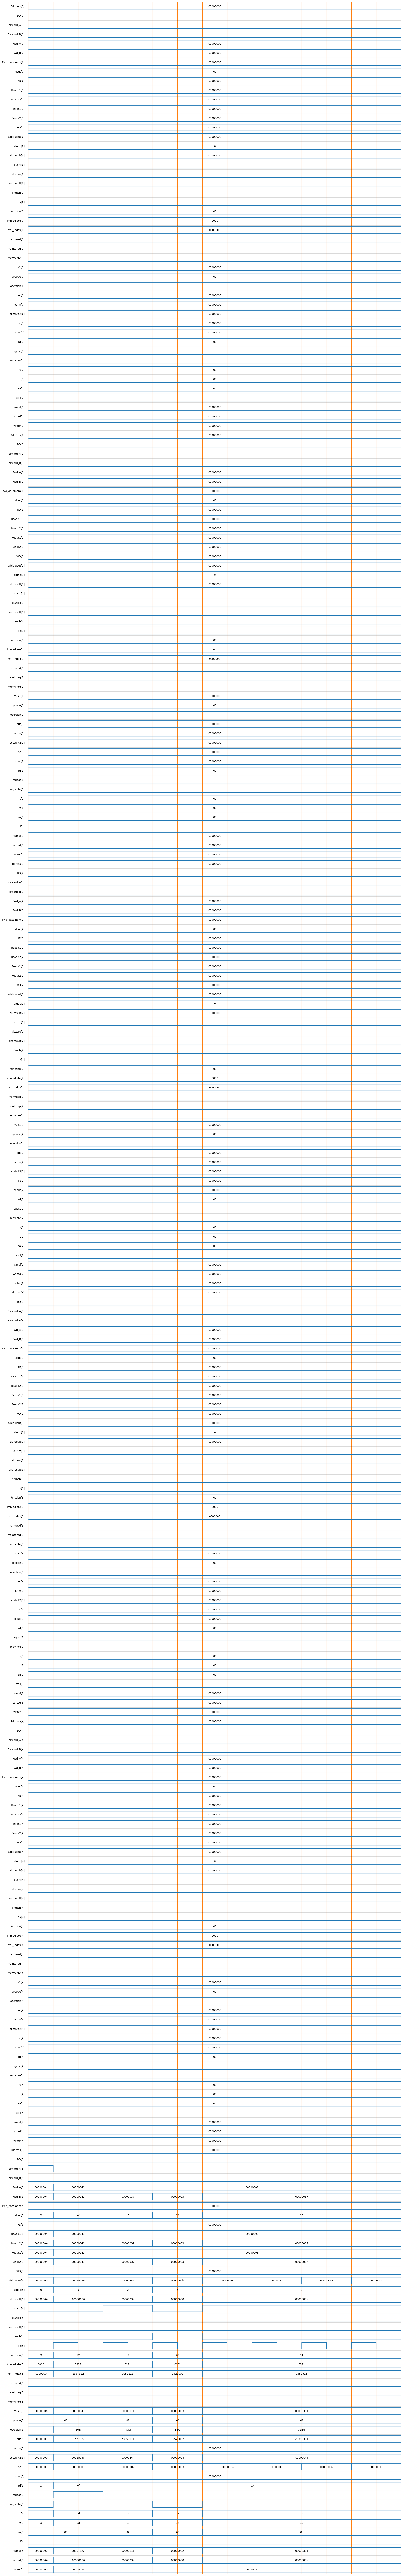

In [ ]:
from myhdl import *
from myhdlpeek import *

pc = Signal(intbv(0)[32:0])
out = Signal(intbv(0)[32:0])
opcode = Signal(intbv(0)[6:0])
rs = Signal(intbv(0)[5:0])
rt = Signal(intbv(0)[5:0])
rd = Signal(intbv(0)[5:0])
sa = Signal(intbv(0)[5:0])
function = Signal(intbv(0)[6:0])
immediate = Signal(intbv(0)[16:0])
instr_index = Signal(intbv(0)[26:0])
clk = Signal(bool(0))
opertion = Signal("")
regdst = Signal(bool(0))
regwrite = Signal(bool(0))
alusrc = Signal(bool(0))
aluop = Signal(intbv(0)[3:0])
memwrite = Signal(bool(0))
memread = Signal(bool(0))
memtoreg = Signal(bool(0))
branch = Signal(bool(0))
DD = Signal(bool(0))
Mout = Signal(intbv(0)[5:0])
Readr1 = Signal(intbv(0)[32:0])
Readr2 = Signal(intbv(0)[32:0])
writer = Signal(intbv(0)[32:0])
writed = Signal(intbv(0)[32:0])
Readd1 = Signal(intbv(0)[32:0])
Readd2 = Signal(intbv(0)[32:0])
transf = Signal(intbv(0)[32:0])
andresult = Signal(bool(0))
mux1 = Signal(intbv(0)[32:0])
Address = Signal(intbv(0)[32:0])
WD = Signal(intbv(0)[32:0])
RD = Signal(intbv(0)[32:0])
aluresult = Signal(intbv(0)[32:0])
aluzero =  Signal(bool(0))
outm = Signal(intbv(0)[32:0])
outshift2 = Signal(intbv(0)[32:0])
pcout = Signal(intbv(0)[32:0])
addaluout =Signal(intbv(0)[32:0])
stall = Signal(bool(0))
fwd_datamem = Signal(intbv(0)[32:0])
forward_a = Signal(bool(0))
forward_b = Signal(bool(0))
fwd_a = Signal(intbv(0)[32:0])
fwd_b = Signal(intbv(0)[32:0])


Peeker(pc, 'pc')
Peeker(out,'out')
Peeker(opcode,'opcode')
Peeker(rs,'rs')
Peeker(rt,'rt')
Peeker(rd,'rd')
Peeker(sa,'sa')
Peeker(function,'function')
Peeker(immediate,'immediate')
Peeker(instr_index,'instr_index')
Peeker(clk,'clk')
Peeker(opertion,'opertion')
Peeker(regdst,'regdst')
Peeker(regwrite,'regwrite')
Peeker(alusrc,'alusrc')
Peeker(aluop,'aluop')
Peeker(memwrite,'memwrite')
Peeker(memread,'memread')
Peeker(memtoreg,'memtoreg')
Peeker(branch,'branch')
Peeker(DD,'DD')
Peeker(Mout,'Mout')
Peeker(Readr1,'Readr1')
Peeker(Readr2,'Readr2')
Peeker(writer,'writer')
Peeker(writed,'writed')
Peeker(Readd1,'Readd1')
Peeker(Readd2,'Readd2')
Peeker(transf,'transf')
Peeker(andresult,'andresult')
Peeker(mux1,'mux1')
Peeker(Address,'Address')
Peeker(WD,'WD')
Peeker(RD,'RD')
Peeker(aluresult,'aluresult')
Peeker(aluzero,'aluzero')
Peeker(outm,'outm')
Peeker(outshift2,'outshift2')
Peeker(pcout,'pcout')
Peeker(addaluout,'addaluout')
Peeker(stall,'stall')
Peeker(forward_a,'Forward_A')
Peeker(forward_b,'Forward_B')
Peeker(fwd_datamem,'Fwd_datamem')
Peeker(fwd_a,'Fwd_A')
Peeker(fwd_b,'Fwd_B')





task_inst = fetching(clk,out,pc,stall)
dec =  decoding(out, opcode, rs, rd, rt, sa, function, immediate,instr_index,stall)
forwarding = forwarding_unit(rs, rt, rd, forward_a, forward_b, stall)
cont = con(opcode,function,opertion,regdst,regwrite,alusrc,aluop,memwrite,memread,memtoreg,branch,stall)
mux_inst = mux(rt,rd,regdst,Mout,stall)
REG_inst = REG(Mout,rs,rt,regwrite,Readr1,Readr2,writer,writed,Readd1,Readd2,stall,forward_a,forward_b,fwd_a,fwd_b)
sig_ins = signex(immediate,transf,stall)
muxalu_ins = muxalu(Readd2,transf,alusrc,mux1,stall)
Alu22 = Alu(Readd1,mux1,aluop,aluresult,aluzero,opertion,stall,fwd_a,fwd_b)
Datammm = Datamem(clk,aluresult, Readd2, memwrite, memread, WD, RD, Address,stall,fwd_datamem)
muxdata_ins = muxdata(memtoreg,RD,aluresult,writed,stall)
and_ins = andg(andresult, aluzero, branch,stall)
shift2_ins = shift2(transf,outshift2,stall)
addalu_ins = addalu(pc, outshift2, addaluout,stall)
branchmux_ins = branchmux(andresult, addaluout,pc,stall)

def fetch_tb():

    @instance
    def monitor():
        for i in range(15):

            yield delay(1)
            clk.next = not clk


    return instances()


# Simulation
sim = Simulation(task_inst,dec,forwarding,cont,mux_inst, REG_inst, sig_ins, muxalu_ins, Alu22, Datammm, muxdata_ins, and_ins, shift2_ins, addalu_ins, branchmux_ins,  fetch_tb(), *Peeker.instances())
sim.run()
Peeker.show_waveforms(width = 25, slope = 0)
Peeker.clear()




In [ ]:
Peeker.clear()
